In [288]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from addict import Dict

from cadet import Cadet

In [289]:
# macOS installation path
Cadet.cadet_path = '/Users/hoangnguyen/cadet-core/cadet/bin/cadet-cli'

In [290]:
# Windows installation path
# Cadet.cadet_path = 'C:/Users/hoang/miniconda3/envs/cadet-env/bin/cadet-cli.exe'

# Example 1: Linear model

In [291]:
# Setting up the model
linear_model = Cadet()
linear_model.root.input.model.nunits = 1

## Example 1: Linear model

The simplest model for adsorption is the [linear model](https://cadet.github.io/master/modelling/binding/linear.html).
Analogously to Henry's law, it describes a linear correlation of the amount of the surface adsorbate to the partial pressure of the adsorptive gas or the concentration of the solute.


Let us consider a shaking flask experiment a `CSTR` (without ingoing or outgoing streams).
In it, we add some porous material s.t. the overal porosity is $0.5$. 
Then, we a solution of a component with $1~mol \cdot L^{-1}$. 


Before defining the adsorption paramters, we start by defining the system of unit operations.

In [292]:
# CSTR
linear_model.root.input.model.unit_000.unit_type = 'CSTR'
linear_model.root.input.model.unit_000.ncomp = 1
linear_model.root.input.model.unit_000.init_volume = 1e-3
linear_model.root.input.model.unit_000.porosity = 0.5
linear_model.root.input.model.unit_000.init_c = [1]
linear_model.root.input.model.unit_000.init_q = [0]

# Sections and Switches
linear_model.root.input.solver.sections.nsec = 1
linear_model.root.input.solver.sections.section_times = [0.0, 10]
linear_model.root.input.solver.user_solution_times = np.linspace(0, 10, 1001)

linear_model.root.input.model.connections.nswitches = 1
linear_model.root.input.model.connections.switch_000.section = 0
linear_model.root.input.model.connections.switch_000.connections = []

In [293]:
# Adsorption
linear_model.root.input.model.unit_000.nbound = [1]
linear_model.root.input.model.unit_000.adsorption_model = 'LINEAR'

linear_model.root.input.model.unit_000.adsorption.is_kinetic = True
linear_model.root.input.model.unit_000.adsorption.lin_ka = [2]
linear_model.root.input.model.unit_000.adsorption.lin_kd = [1]

In [294]:
linear_model.root.input.model.solver.gs_type = 1
linear_model.root.input.model.solver.max_krylov = 0
linear_model.root.input.model.solver.max_restarts = 10
linear_model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
linear_model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
linear_model.root.input.solver.time_integrator.abstol = 1e-6
linear_model.root.input.solver.time_integrator.algtol = 1e-10
linear_model.root.input.solver.time_integrator.reltol = 1e-6
linear_model.root.input.solver.time_integrator.init_step_size = 1e-6
linear_model.root.input.solver.time_integrator.max_steps = 1000000

In [295]:
# Return data
linear_model.root.input['return'].split_components_data = 0
linear_model.root.input['return'].split_ports_data = 0
linear_model.root.input['return'].unit_000.write_solution_bulk = 1
linear_model.root.input['return'].unit_000.write_solution_inlet = 1
linear_model.root.input['return'].unit_000.write_solution_outlet = 1
linear_model.root.input['return'].unit_000.write_solution_solid = 1

In [296]:
# Running simulation
linear_model.filename = 'linear-adsorption.h5'
linear_model.save()

data = linear_model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    linear_model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


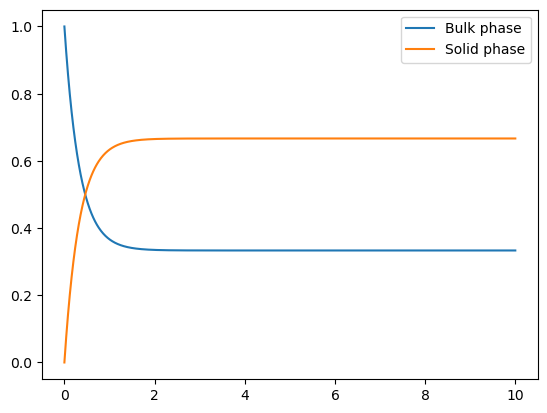

In [297]:
# Plot results
plt.figure()
time = linear_model.root.output.solution.solution_times
solution_bulk = linear_model.root.output.solution.unit_000.solution_bulk
solution_solid = linear_model.root.output.solution.unit_000.solution_solid
plt.plot(time, solution_bulk, label='Bulk phase')
plt.plot(time, solution_solid, label='Solid phase')
plt.legend()

# Example 2: Linear adsorption model with linear concentration gradient

In [298]:
linear_gradient_model = Cadet()
linear_gradient_model.root.input.model.nunits = 2

In [299]:
n_comp = 2
Q = 1e-3

# INLET
linear_gradient_model.root.input.model.unit_000.unit_type = 'INLET'
linear_gradient_model.root.input.model.unit_000.ncomp = n_comp
linear_gradient_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR
linear_gradient_model.root.input.model.unit_001.unit_type = 'CSTR'
linear_gradient_model.root.input.model.unit_001.ncomp = n_comp
linear_gradient_model.root.input.model.unit_001.init_volume = 1e-3
linear_gradient_model.root.input.model.unit_001.porosity = 0.5
linear_gradient_model.root.input.model.unit_001.init_c = n_comp*[0]
linear_gradient_model.root.input.model.unit_001.init_q = n_comp*[0]
linear_gradient_model.root.input.model.unit_001.flow_rate_filter = Q

# Sections and Switches
linear_gradient_model.root.input.solver.sections.nsec = 1
linear_gradient_model.root.input.solver.sections.section_times = [0.0, 1]
linear_gradient_model.root.input.solver.user_solution_times = np.linspace(0, 1, 1001)

linear_gradient_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[0]
linear_gradient_model.root.input.model.unit_000.sec_000.lin_coeff = n_comp*[1]

linear_gradient_model.root.input.model.connections.nswitches = 1
linear_gradient_model.root.input.model.connections.switch_000.section = 0
linear_gradient_model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q]

In [300]:
adsorption_model = 'LINEAR'
adsorption_parameters = Dict()
adsorption_parameters.is_kinetic = False
adsorption_parameters.lin_ka = [3, 2]
adsorption_parameters.lin_kd = [1, 1]

linear_gradient_model.root.input.model.unit_001.nbound = n_comp*[1]
linear_gradient_model.root.input.model.unit_001.adsorption_model = adsorption_model
linear_gradient_model.root.input.model.unit_001.adsorption = adsorption_parameters

In [301]:
linear_gradient_model.root.input.model.solver.gs_type = 1
linear_gradient_model.root.input.model.solver.max_krylov = 0
linear_gradient_model.root.input.model.solver.max_restarts = 10
linear_gradient_model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
linear_gradient_model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
linear_gradient_model.root.input.solver.time_integrator.abstol = 1e-6
linear_gradient_model.root.input.solver.time_integrator.algtol = 1e-10
linear_gradient_model.root.input.solver.time_integrator.reltol = 1e-6
linear_gradient_model.root.input.solver.time_integrator.init_step_size = 1e-6
linear_gradient_model.root.input.solver.time_integrator.max_steps = 1000000

In [302]:
# Return data
linear_gradient_model.root.input['return'].split_components_data = 0
linear_gradient_model.root.input['return'].split_ports_data = 0
linear_gradient_model.root.input['return'].unit_001.write_solution_bulk = 1
linear_gradient_model.root.input['return'].unit_001.write_solution_inlet = 1
linear_gradient_model.root.input['return'].unit_001.write_solution_outlet = 1
linear_gradient_model.root.input['return'].unit_001.write_solution_solid = 1

In [303]:
# Running simulation
linear_gradient_model.filename = 'linear-adsorption-gradient.h5'
linear_gradient_model.save()

data = linear_gradient_model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    linear_gradient_model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


Text(0, 0.5, '$c_{solid}$')

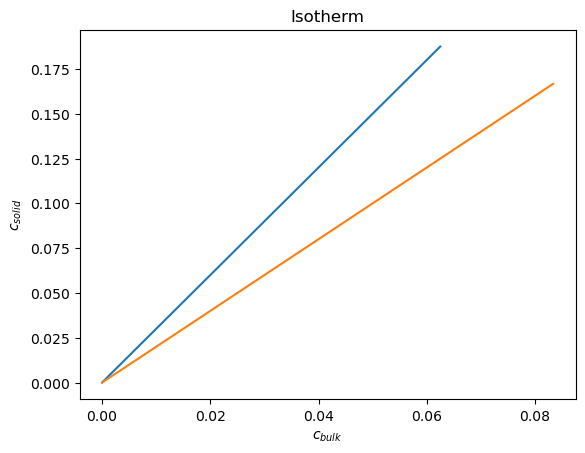

In [304]:
# Plot results
solution_bulk = linear_gradient_model.root.output.solution.unit_001.solution_bulk
solution_solid = linear_gradient_model.root.output.solution.unit_001.solution_solid

plt.figure()
plt.title('Isotherm')
plt.plot(solution_bulk, solution_solid)
plt.xlabel('$c_{bulk}$')
plt.ylabel('$c_{solid}$')

# Example 3: Multi component Langmuir model

## Example 3: Multi component Langmuir model

Usually, the linear isotherm can only be assumed for very low solute concentrations.
At higher, higher concentrations the limited number of available binding sites on the surface of the adsorbent also needs to be considered which the [Langmuir equation](https://cadet.github.io/master/modelling/binding/multi_component_langmuir.html) takes into account.

$$q = q_{sat} \cdot \frac{b \cdot c}{1 + b \cdot c} = \frac{a \cdot c}{1 + b \cdot c}$$

***with:*** 
> $q_{Sat}$: saturation loading  
> $b$ = equilibrium factor

***Assumptions:***
- All of the adsorption sites are equivalent, and each site can only accommodate one molecule
- The surface is energetically homogeneous
- Adsorbed molecules do not interact
- There are no phase transitions
- At the maximum adsorption, only a monolayer is formed

For this example, we will introduce a concentration step to the `CSTR`. 
We consider two components, both with an inital concentration of $0~mM$, but with different binding strengths.

In [305]:
langmuir_model = Cadet()
langmuir_model.root.input.model.nunits = 3

In [306]:
# INTLET
langmuir_model.root.input.model.unit_000.unit_type = 'INLET'
langmuir_model.root.input.model.unit_000.ncomp = 2
langmuir_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# CSTR
langmuir_model.root.input.model.unit_001.unit_type = 'CSTR'
langmuir_model.root.input.model.unit_001.ncomp = 2
langmuir_model.root.input.model.unit_001.init_volume = 1e-3
langmuir_model.root.input.model.unit_001.porosity = 0.5
langmuir_model.root.input.model.unit_001.init_c = [0, 0]
langmuir_model.root.input.model.unit_001.init_q = [0, 0]

# OUTLET
langmuir_model.root.input.model.unit_002.unit_type = 'OUTLET'
langmuir_model.root.input.model.unit_002.ncomp = 2

# Sections and Switches
langmuir_model.root.input.solver.sections.nsec = 1
langmuir_model.root.input.solver.sections.section_times = [0.0, 10]
langmuir_model.root.input.solver.user_solution_times = np.linspace(0, 10, 1001)
langmuir_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[1.0,]


langmuir_model.root.input.model.connections.nswitches = 1
langmuir_model.root.input.model.connections.switch_000.section = 0
langmuir_model.root.input.model.connections.switch_000.connections = [
    0, 1, -1, -1, 1e-3,
    1, 2, -1, -1, 1e-3
]

In [307]:
langmuir_model.root.input.model.unit_001.nbound = [1, 1]
langmuir_model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'

langmuir_model.root.input.model.unit_001.adsorption.is_kinetic = False
langmuir_model.root.input.model.unit_001.adsorption.mcl_ka = [3, 1]
langmuir_model.root.input.model.unit_001.adsorption.mcl_kd = [1, 1]
langmuir_model.root.input.model.unit_001.adsorption.mcl_qmax = [1, 1]

In [308]:
langmuir_model.root.input.model.solver.gs_type = 1
langmuir_model.root.input.model.solver.max_krylov = 0
langmuir_model.root.input.model.solver.max_restarts = 10
langmuir_model.root.input.model.solver.schur_safety = 1e-8

# Number of cores for parallel simulation
langmuir_model.root.input.solver.nthreads = 1

# Tolerances for the time integrator
langmuir_model.root.input.solver.time_integrator.abstol = 1e-6
langmuir_model.root.input.solver.time_integrator.algtol = 1e-10
langmuir_model.root.input.solver.time_integrator.reltol = 1e-6
langmuir_model.root.input.solver.time_integrator.init_step_size = 1e-6
langmuir_model.root.input.solver.time_integrator.max_steps = 1000000

In [313]:
# Return data
langmuir_model.root.input['return'].split_components_data = 0
langmuir_model.root.input['return'].split_ports_data = 0
langmuir_model.root.input['return'].unit_001.write_solution_inlet = 1
langmuir_model.root.input['return'].unit_001.write_solution_outlet = 1
langmuir_model.root.input['return'].unit_001.write_solution_bulk = 1
langmuir_model.root.input['return'].unit_001.write_solution_particle = 1
langmuir_model.root.input['return'].unit_001.write_solution_solid = 1
langmuir_model.root.input['return'].unit_001.write_solution_flux = 1
langmuir_model.root.input['return'].unit_001.write_solution_volume = 1
langmuir_model.root.input['return'].unit_001.write_coordinates = 1
langmuir_model.root.input['return'].unit_001.write_sens_outlet = 1

langmuir_model.root.input['return'].unit_000 = langmuir_model.root.input['return'].unit_001

In [314]:
time = langmuir_model.root.output.solution.solution_times
solution_bulk = langmuir_model.root.output.solution.unit_001.solution_bulk
solution_solid = langmuir_model.root.output.solution.unit_001.solution_solid

In [315]:
# Running simulation
langmuir_model.filename = 'langmuir.h5'
langmuir_model.save()

data = langmuir_model.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    langmuir_model.load()
else:
    print(data)
    raise Exception("Simulation failed")

Simulation completed successfully


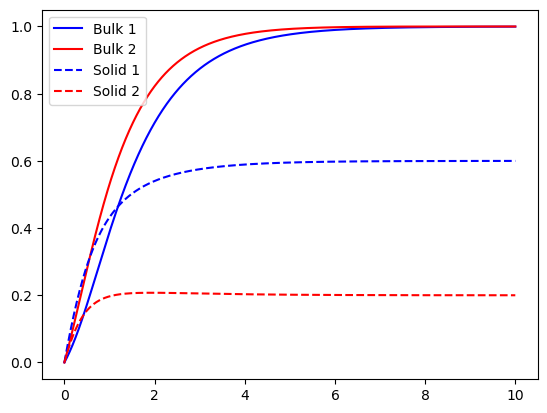

In [316]:
plt.figure()
colors = ['b', 'r']
for c in range(n_comp):
    plt.plot(time, solution_bulk[:,c], '{}'.format(colors[c]), label='Bulk {}'.format(c+1))
for c in range(n_comp):
    plt.plot(time, solution_solid[:,c], '{}--'.format(colors[c]), label='Solid {}'.format(c+1))
plt.legend()